In [1]:
import cubewalkers as cw
import cupy as cp
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size':20})

In [2]:
IMPORT_RULES_FROM_FILES = True
models_dir = 'corrected_models' # cell_collective OR corrected_models
cc_models_dir = f'./models/{models_dir}/'
if IMPORT_RULES_FROM_FILES:
    from os import listdir
    
    sync_models = {}
    for fname in listdir(cc_models_dir):
        with open(cc_models_dir+fname) as rulefile:
            name = fname.replace('.txt','')
            rules = rulefile.read()
            sync_models[name]=cw.Model(rules)
else:
    from cana.datasets.bio import load_all_cell_collective_models
    def cell_collective_models():
        return {BN.name:cw.Model(cw.conversions.network_rules_from_cana(BN)) 
                for BN in load_all_cell_collective_models()}
    sync_models = cell_collective_models()
    for name,model in sync_models.items():
        with open(cc_models_dir+name+'.txt','w') as rulefile:
            rulefile.write(model.rules)

total_models = len(sync_models)
async_models = deepcopy(sync_models)

In [3]:
def simulate_models(models, sync=True, W_max=125000):
    for model_idx, (model_name, model) in enumerate(sorted(models.items())):
        model.n_walkers = W_max
        N = model.n_variables
        T = 100
        
        model.n_time_steps = T

        print(f"Simulating Model {model_name} . . .")
        if sync:
            model.simulate_ensemble(averages_only=False,
                                    maskfunction=cw.update_schemes.synchronous,
                                    threads_per_block=(16, 16))
        else:
            model.simulate_ensemble(averages_only=False,
                                    maskfunction=cw.update_schemes.asynchronous,
                                    threads_per_block=(16, 16))
            
        
        
        print(f"Progress: {(model_idx+1)}/{total_models}")

In [4]:
simulate_models(sync_models,sync=True)

Simulating Model Apoptosis Network . . .
Progress: 1/72
Simulating Model Arabidopsis thaliana Cell Cycle . . .
Progress: 2/72
Simulating Model Aurora Kinase A in Neuroblastoma . . .
Progress: 3/72
Simulating Model B bronchiseptica and T retortaeformis coinfection . . .
Progress: 4/72
Simulating Model B cell differentiation . . .
Progress: 5/72
Simulating Model BT474 Breast Cell Line Long-term ErbB Network . . .
Progress: 6/72
Simulating Model BT474 Breast Cell Line Short-term ErbB Network . . .
Progress: 7/72
Simulating Model Bordetella bronchiseptica . . .
Progress: 8/72
Simulating Model Bortezomib Responses in U266 Human Myeloma Cells . . .
Progress: 9/72
Simulating Model Budding Yeast Cell Cycle . . .
Progress: 10/72
Simulating Model Budding Yeast Cell Cycle 2009 . . .
Progress: 11/72
Simulating Model CD4 T cell signaling . . .
Progress: 12/72
Simulating Model CD4+ T Cell Differentiation and Plasticity . . .
Progress: 13/72
Simulating Model CD4+ T cell Differentiation . . .
Progress

In [5]:
sync_models['Apoptosis Network'].trajectories.shape

(101, 41, 125000)

In [6]:
w_vals = [1,2,5,10,20,50,100,200,500,1000,2000,2500]
t_vals = [0,10,100]

pts = {}
p0s = {}
for tf in t_vals:
    pts[tf] = []
    for w in w_vals:
        for model in sync_models.values():
            stds = cp.std(cp.array([cp.mean(model.trajectories[tf,:,i*w:(i*w+w)],axis=1) for i in range(50)]),axis=0)
            arr = [(w,v) for v in stds.get()]
            pts[tf]+=arr
    

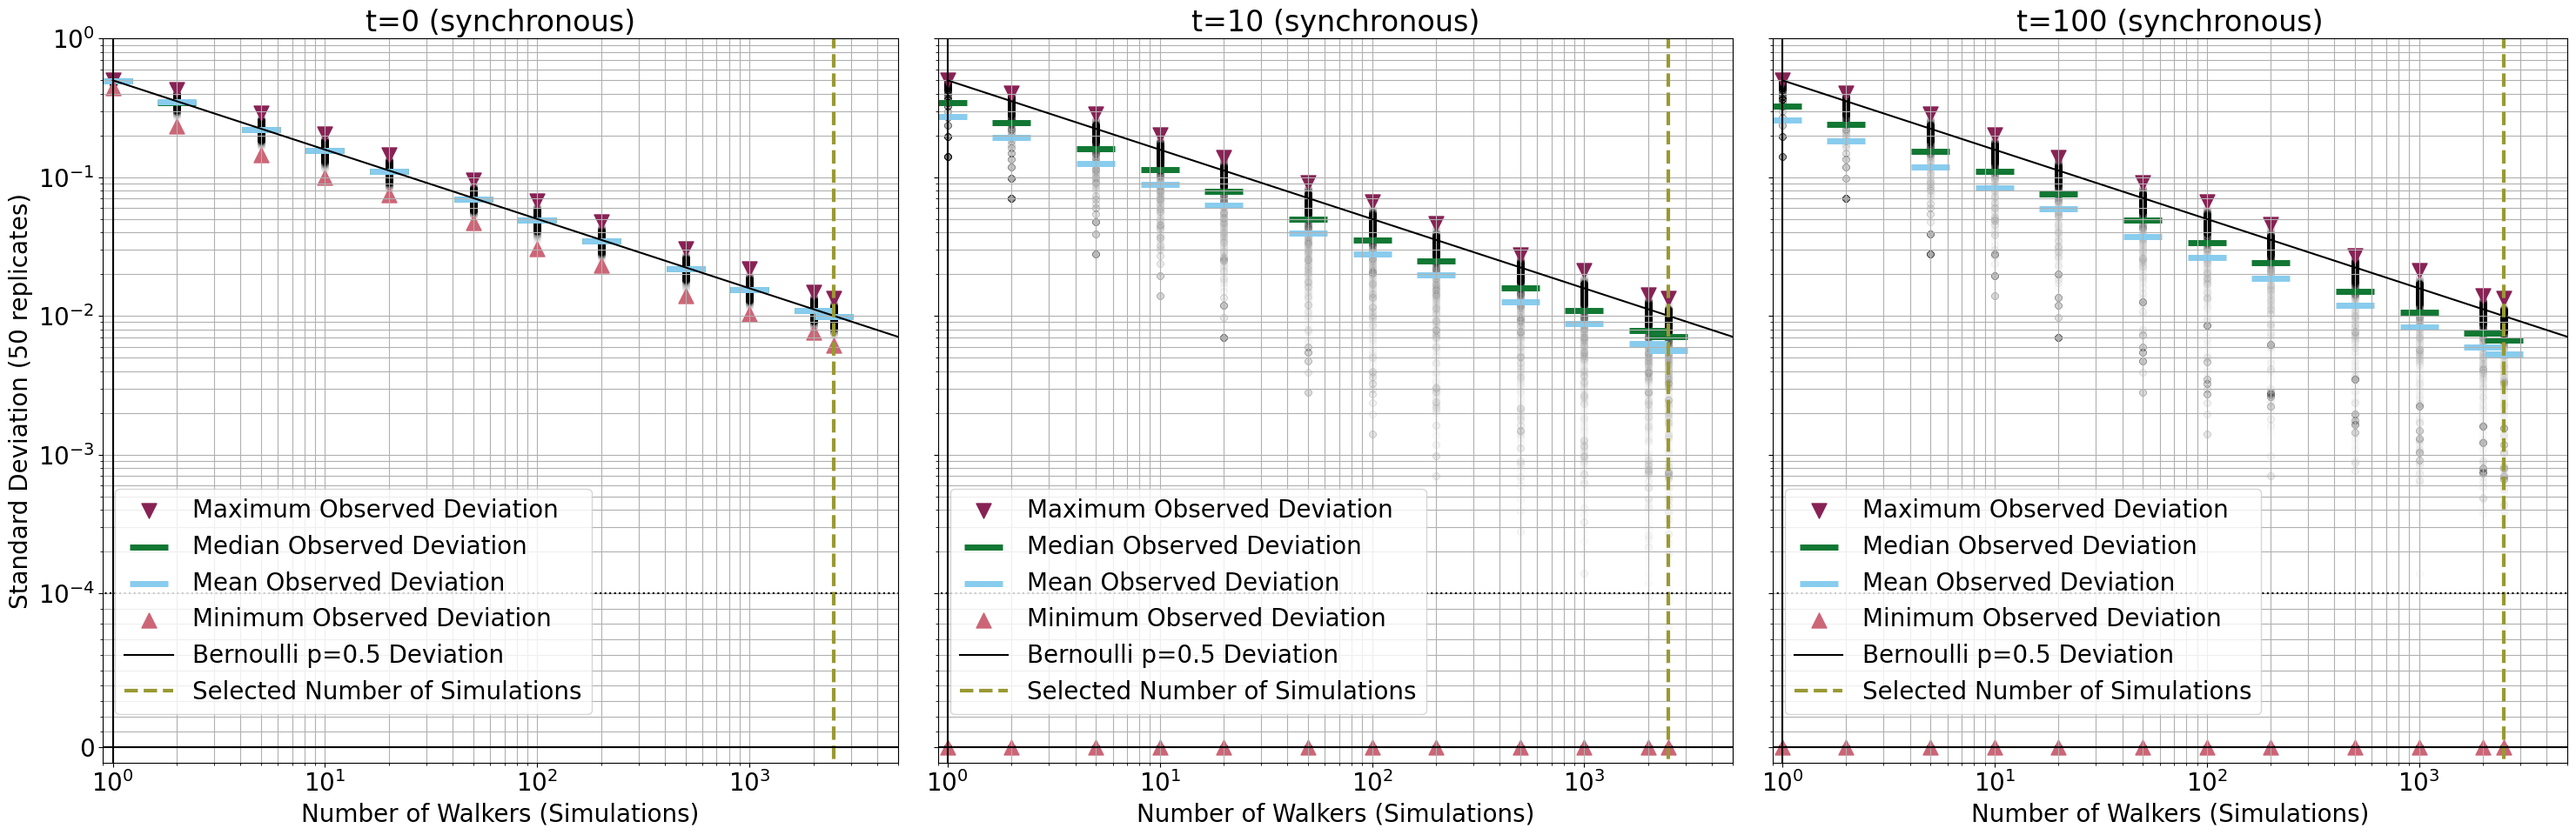

In [7]:
from statistics import median, mean

fig,ax = plt.subplots(1,3,figsize=(30,10),sharey=True)
fig.set_facecolor('white')

first = True
for ind,tf in enumerate(t_vals):
    x,y = zip(*pts[tf])
    ax[ind].scatter(x,y,c='k',alpha=0.005)
    
    ymax=[]
    ymin=[]
    ymed=[]
    yavg=[]
    for w in w_vals:
        yw = [p[1] for p in pts[tf] if p[0] == w]
        ymax.append(max(yw))
        ymin.append(min(yw))
        ymed.append(median(yw))
        yavg.append(mean(yw))
    # '#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD'    
    ax[ind].scatter(w_vals,ymax,c='#882255',marker='v',s=150,label='Maximum Observed Deviation')
    ax[ind].scatter(w_vals,ymed,c='#117733',marker='_',s=1000,linewidths=5,label='Median Observed Deviation')
    ax[ind].scatter(w_vals,yavg,c='#88CCEE',marker='_',s=1000,linewidths=5,label='Mean Observed Deviation')
    ax[ind].scatter(w_vals,ymin,c='#CC6677',marker='^',s=150,label='Minimum Observed Deviation')
    
    ax[ind].plot([1,10000],[0.5,0.5/100],c='k',linestyle='-',label='Bernoulli p=0.5 Deviation')
    
    # ax[ind].set_xscale('symlog',linthresh=0.0001)
    ax[ind].set_xscale('log')
    ax[ind].set_yscale('symlog',linthresh=0.0001)
    #ax[ind].set_yscale('log')
    ax[ind].set_xlim((0.9,5000))
    ax[ind].set_ylim((-0.00001,1))
    ax[ind].set_yticks([10**(-x) for x in range(5)]+[0],minor=False)
    ax[ind].set_yticks([0.1*i*10**(-x) for x in range(5) for i in range(1,11)],minor=True)
    
    ax[ind].set_xlabel('Number of Walkers (Simulations)')
    if first:
        ax[ind].set_ylabel('Standard Deviation (50 replicates)')
    ax[ind].set_title(f't={tf} (synchronous)')
    
    ax[ind].vlines(2500,-2,2,linestyles='dashed',colors='#999933',linewidths=3,label='Selected Number of Simulations')
    
    ax[ind].hlines(1e-4,-1,100_000,linestyles='dotted',colors='k')
    ax[ind].hlines(0,-1,100_000,linestyles='-',colors='k')
    ax[ind].vlines(1,-2,2,linestyles='-',colors='k')
    
    ax[ind].grid('both','both')
    ax[ind].legend(loc='lower left',bbox_to_anchor=(0.0,0.05))
    first = False

fig.tight_layout()
plt.savefig(f'./data/{models_dir}/figures/convergence.png')
plt.savefig(f'./data/{models_dir}/figures/convergence.pdf')
plt.show()